In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import heatmap visualization
import seaborn as sns
# Import additional necessary libraries for ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [14]:
# Load the datasets
X_train = pd.read_csv('Dataset/X_train.csv')
X_val = pd.read_csv('Dataset/X_val.csv')
y_train = pd.read_csv('Dataset/y_train.csv')
y_val = pd.read_csv('Dataset/y_val.csv')
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

# Check for missing values in the datasets
print("\nMissing values in X_train:")
print(X_train.isnull().sum())
print("\nMissing values in X_val:")
print(X_val.isnull().sum().sum())
print("\nMissing values in y_train:")
print(y_train.isnull().sum().sum())
print("\nMissing values in y_val:")
print(y_val.isnull().sum().sum())

X_train shape: (1608, 9)
X_val shape: (201, 9)
y_train shape: (1608, 1)
y_val shape: (201, 1)

Missing values in X_train:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

Missing values in X_val:
0

Missing values in y_train:
0

Missing values in y_val:
0


In [5]:
# Set up the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [500, 1000],
    'max_depth': [5, 10],
    'min_child_weight': [2, 4],
    'gamma': [0.5, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [6]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(objective='binary:logistic', nthread=-2, random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=3, verbose=3, random_state=42)

# Fit the model
random_search.fit(X_train, y_train.values.ravel())

# Best estimator
best_xgb = random_search.best_estimator_

# Evaluate the best estimator on validation data
y_val_pred = best_xgb.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
print(f"Best Model Parameters: {random_search.best_params_}\nValidation Accuracy: {acc_val:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Model Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}
Validation Accuracy: 0.6965


In [15]:
# Load the test dataset and evaluate the model
X_test = pd.read_csv('Dataset/X_test.csv')
y_test = pd.read_csv('Dataset/y_test.csv')
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check for missing values in the test dataset
print("\nMissing values in X_test:")
print(X_test.isnull().sum().sum())
print("\nMissing values in y_test:")
print(y_test.isnull().sum().sum())

X_test shape: (202, 9)
y_test shape: (202, 1)

Missing values in X_test:
0

Missing values in y_test:
0


In [8]:
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6584


In [9]:
# Generate and print the classification report
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       120
           1       0.61      0.44      0.51        82

    accuracy                           0.66       202
   macro avg       0.64      0.62      0.62       202
weighted avg       0.65      0.66      0.65       202



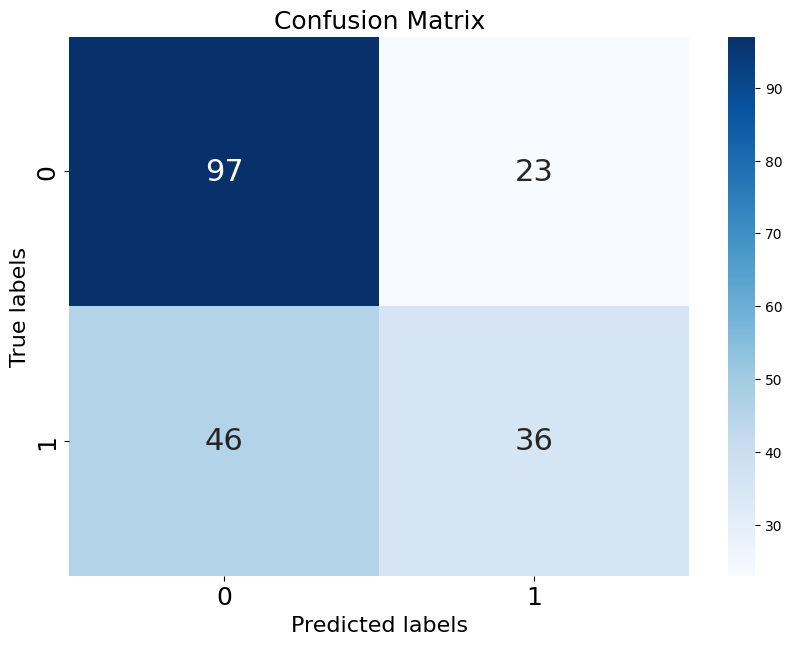

In [24]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 22})
plt.xlabel('Predicted labels', fontsize=16) 
plt.ylabel('True labels', fontsize=16)  
plt.title('Confusion Matrix', fontsize=18)  
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18) 
plt.show()

ROC AUC Score: 0.6944


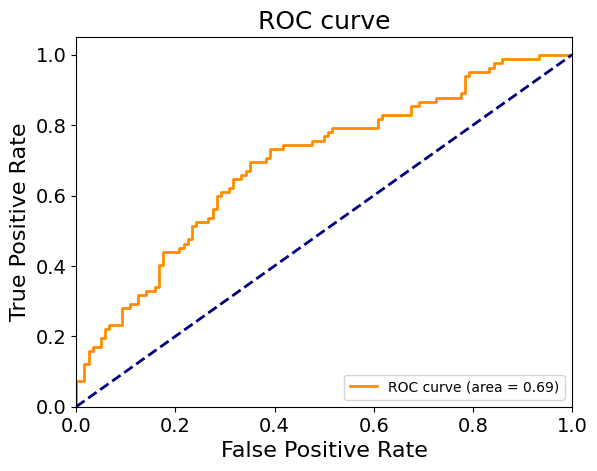

In [28]:
# Predict probabilities for the test set
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve data
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('ROC curve', fontsize=18)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.legend(loc="lower right")
plt.show()